In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE
from pylab import rcParams

In [3]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

In [4]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

You are going to run models on the test set. Are you sure?


In [5]:
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model11 = architecture.base(num_classes=10, **architecture.kwargs)
model12 = architecture.base(num_classes=10, **architecture.kwargs)
m = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve3/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve4/checkpoint-30.pt')['model_state'])

In [6]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [7]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [8]:
def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [9]:
distance(model1, model2), distance(model11, model12)

(39.98046, 36.63083)

## Making dataset 

In [10]:
ind = 1
T = True
S = []
B = []
while ind<20:

    ckpt = 'curves_mnist/LinearOneLayer/LongTraining/curve'+str(ind)+'/checkpoint-30.pt'
    checkpoint = torch.load(ckpt)
    m.load_state_dict(checkpoint['model_state'])
    
    S.append(samples(m))
    B.append(list(m.parameters())[-1].data.numpy())
    ind+=1
    
S = np.concatenate(S)

In [11]:
# len(S)/512

In [12]:
from torch.optim.lr_scheduler import StepLR

def train(flow, model1, model2, epochs=20, lr=1e-5, batchsize=512, step=10, test_every=20):
    flow.cuda();
    flow.train();
    trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters()) # list of all trainable parameters in a flow
    optimizer = torch.optim.Adam(trainable_parametrs, lr=lr, weight_decay=1e-4)# choose an optimizer, use module torch.optim
    scheduler = StepLR(optimizer, step_size=50, gamma=0.9)# decrease learning rate by torch.optim.lr_scheduler

    for epoch in range(1, epochs+1):  
        scheduler.step()
        flow.train()
        
        t = time.time()
        total_loss = 0

        for X in iterate_minibatches(S, batchsize):

            loss = -flow.log_prob(X).mean() #  compute the maximum-likelihood loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss+=loss
        
        total_loss /=(len(S)//batchsize)
        if epoch % step == 0:
            print('epoch %s:' % epoch, 'loss = %.3f' % total_loss, 'time = %.2f' %  (time.time()-t))
        if epoch % test_every == 0:
            test_flow(S, model1, model2, flow, N=2000)
        if epoch % 50 ==0:
            utils.save_checkpoint(
                'flows_checkpoints/IAFjn',
                epoch,
                model_state=IAF_flow.state_dict(),
                optimizer_state=None
            )


## Generator 

In [13]:
def iterate_minibatches(train_data, batchsize):
    indices = np.random.permutation(np.arange(len(train_data)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield torch.FloatTensor(train_data[ix]).cuda()

In [14]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(795), torch.eye(795))

In [15]:
N = 2
X = torch.FloatTensor(S[:N]).cuda()

In [16]:
# X.shape

In [17]:
def get_model(W, B):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = W.cpu().data.numpy()
    SIZE = 2000

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

def test_flow(S, model1, model2, flow, N=2000):
    
    rcParams['figure.figsize'] = 12, 10
    rcParams['figure.dpi'] = 100

    model1.cuda(), model2.cuda(), flow.cuda()
    model1.eval(), model2.eval(), flow.eval()
    print('copmuting samples...')
    X = torch.FloatTensor(S[:N]).cuda()
    X_sample = X.data.cpu().numpy()
    X_prior = prior.sample((N,)).cpu().data.numpy()
    X_flow = flow.sample(N, ).data.cpu().numpy()
    X_sample_prior = flow.f(torch.FloatTensor(X_sample).cuda())[0].data.cpu().numpy()
    
    print('drawing...')
    i, j = 500, -1
    fig, axes = plt.subplots(2, 2,)
    axes[0, 0].set_title('Samples')
    axes[0, 0].scatter(X_sample[:, i], X_sample[:, j])
    axes[0, 1].set_title('Prior')
    axes[0, 1].scatter(X_prior[:, i], X_prior[:, j])
    axes[1, 0].set_title('Flow sampling')
    axes[1, 0].scatter(X_flow[:, i], X_flow[:, j])
    axes[1, 1].set_title('Map from samples to prior')
    axes[1, 1].scatter(X_sample_prior[:, i], X_sample_prior[:, j]) 
    plt.show()
    
    print('computing Arc model...')
    W1 = samples(model1)
    W2 = samples(model2)
    
#     flow.cpu()
    W_pre = 1/np.sqrt(2)*flow.f(torch.FloatTensor(W1).cuda())[0]+1/np.sqrt(2)*flow.f(torch.FloatTensor(W2).cuda())[0]
    W = flow.g(W_pre)
    B = []
    B.append(list(model1.parameters())[-1].data.cpu().numpy())
    B.append(list(model2.parameters())[-1].data.cpu().numpy())
    B = np.array(B)
    
    model_sampled = get_model(W, B)
    test(model_sampled)
    
    if N==2000:
        print('computing Sampling from flow model...')
        X_flow = flow.sample(N, ).data.cpu()
        
        model_flow = get_model(X_flow, B)
        test(model_flow)
#         return model_sampled, model_flow
    
    return model_sampled
    

## IAF

In [18]:
from torch.nn.init import xavier_normal
from torch.nn.parameter import Parameter
import math

class AutoregressiveLinear(nn.Module):
    def __init__(self, dim_in, out_size, bias=True, ):
        super(AutoregressiveLinear, self).__init__()

        self.in_size = dim_in
        self.out_size = out_size

        self.weight = Parameter(torch.Tensor(self.in_size, self.out_size))

        if bias:
            self.bias = Parameter(torch.Tensor(self.out_size))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self, ):
        stdv = 1. / math.sqrt(self.out_size)

        self.weight = nn.init.xavier_normal_(self.weight)

        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        if input.dim() == 2 and self.bias is not None:
            return torch.addmm(self.bias, input, self.weight.tril(-1))

        output = input @ self.weight.tril(-1)
        if self.bias is not None:
            output += self.bias
        return output
    
class AutoregressiveLinearU(nn.Module):
    def __init__(self, dim_in, out_size, bias=True, ):
        super(AutoregressiveLinearU, self).__init__()

        self.in_size = dim_in
        self.out_size = out_size

        self.weight = Parameter(torch.Tensor(self.in_size, self.out_size))

        if bias:
            self.bias = Parameter(torch.Tensor(self.out_size))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self, ):
        stdv = 1. / math.sqrt(self.out_size)

        self.weight = nn.init.xavier_normal_(self.weight)

        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        if input.dim() == 2 and self.bias is not None:
            return torch.addmm(self.bias, input, self.weight.triu(1))

        output = input @ self.weight.triu(1)
        if self.bias is not None:
            output += self.bias
        return output
    
class IAF_block(nn.Module):
    def __init__(self, dim_in, dim_middle, Low=True):
        super(IAF_block, self).__init__()

        self.z_size = dim_in
        self.dim_middle = dim_middle
        self.Low = Low
        self.h = nn.LeakyReLU()
        affine = True

        if Low:
            self.m = nn.Sequential(
                AutoregressiveLinear(self.z_size, self.dim_middle),
                self.h,
                AutoregressiveLinear(self.dim_middle, self.dim_middle),
                self.h,
                AutoregressiveLinear(self.dim_middle, self.z_size)
            )

            self.s = nn.Sequential(
                AutoregressiveLinear(self.z_size, self.dim_middle),
                self.h,
                AutoregressiveLinear(self.dim_middle, self.dim_middle),
                self.h,
                AutoregressiveLinear(self.dim_middle, self.z_size)
            )
        else:
            self.m = nn.Sequential(
                AutoregressiveLinearU(self.z_size, self.dim_middle),
                self.h,
                AutoregressiveLinearU(self.dim_middle, self.dim_middle),
                self.h,
                AutoregressiveLinearU(self.dim_middle, self.z_size)
            )

            self.s = nn.Sequential(
                AutoregressiveLinearU(self.z_size, self.dim_middle),
                self.h,
                AutoregressiveLinearU(self.dim_middle, self.dim_middle),
                self.h,
                AutoregressiveLinearU(self.dim_middle, self.z_size)
            )

    def forward(self, z):

        self.mu_z  = self.m(z)
        self.log_sigma_z = self.s(z)
        self.log_sigma_z = torch.clamp(self.log_sigma_z, -1, 1)  
        
#         self.sigma_z = nn.Sigmoid()(s)
        
#         z = self.sigma_z*z+(1-self.sigma_z)*self.mu_z 
        z = self.log_sigma_z.exp()*z+self.mu_z 

        return z, self.log_sigma_z
    
    
class BatchNorm(nn.Module):
    def __init__(self, dim_in):
        super(BatchNorm, self).__init__()

        self.mu = torch.zeros(dim_in).cuda()
        self.sig2 = torch.zeros(dim_in).cuda()+0.1
        self.momentum=0.1
        
    def forward(self, x):

        if self.training:
            mu = x.mean(0)
            sig2 = (x-mu).pow(2).mean(0)  
            x = (x-mu)/(sig2 + 1.0e-6 ).sqrt()
            self.mu = self.momentum*mu + (1-self.momentum)*self.mu
            self.sig2 =  self.momentum*sig2 + (1-self.momentum)*self.sig2
            return x, sig2+1.0e-6 
        else: 
            x = (x-self.mu)/(self.sig2+1.0e-6).sqrt()
            return x, self.sig2+1.0e-6 

    
class Flow_IAF(nn.Module):
    def __init__(self, prior):
        super(Flow_IAF, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior 
        self.len = 15
        self.s = torch.nn.ModuleList([IAF_block(dim_in=795, dim_middle=795, Low=i%2) for i in range(self.len)])
        self.b = torch.nn.ModuleList([BatchNorm(dim_in=795) for _ in range(self.len)])
        
        self.verbose = False
        self.batch_norm = True
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        z = z.detach()
        for s, b in zip(reversed(self.s), reversed(self.b)):
            if s.Low:
                crange = reversed(range(z.size()[1]))               
            else:
                crange = range(z.size()[1])
                
            for i in crange:

                _, log_sigma = s(z.detach())
                mu = s.mu_z
                if self.verbose:
                    print(i)
                    print('z1', z[:, i] )
                z[:, i] = ((z[:, i] - mu[:, i])*(-log_sigma[:, i]).exp()).detach()
                if self.verbose:
                    print('mu', mu[:, i])
                    print('sigma', (-log_sigma[:, i]).exp())
                    print('z2', z[:, i] ) 
            
            if self.verbose:
                print('z1-bn', z)
            if self.batch_norm:
                z = z*(b.sig2+1.0e-6).sqrt()+b.mu
#             print('sigma, mu', b.sig2[0], b.mu[0])
            if self.verbose:
                print('z2-bn', z)
            
        x = z
        return x
    


    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = 0
        
#         batch_size = z.size()[0]
        
        for i, (s, b) in enumerate(zip(self.s, self.b)):
            
            if self.batch_norm:
                z, sig2 = b(z)
                
            z, log_sigma = s(z)
            if self.batch_norm:
                log_det_J += (log_sigma-0.5*sig2.log()).sum(-1)
            else:
                log_det_J += log_sigma.sum(-1)
        
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        
        logp = -0.5*np.log(np.pi*2)-0.5*z.pow(2)
        logp = logp.sum(-1)
        
#         logp = self.prior.log_prob(z.cpu()).cuda()
#         print('logp', logp.shape)
        
        return logp+log_det_J
        
    def sample(self, K): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)

        z = self.prior.sample((K, )).cuda()
        x = self.g(z)
        
        return x
    


In [19]:
IAF_flow = Flow_IAF(prior)
IAF_flow.cuda();

In [20]:
# IAF_flow.eval()
# i, j = 1, 500
# IAF_flow.g(IAF_flow.f(X)[0])[i][j], X[i][j]

In [21]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve3/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve4/checkpoint-30.pt')['model_state'])

epoch 1: loss = -2006.212 time = 3.12
epoch 2: loss = -2046.631 time = 3.02
epoch 3: loss = -2063.765 time = 3.02
epoch 4: loss = -2077.626 time = 3.02
epoch 5: loss = -2090.810 time = 3.03
epoch 6: loss = -2105.458 time = 3.04
epoch 7: loss = -2121.590 time = 3.04
epoch 8: loss = -2138.643 time = 3.04
epoch 9: loss = -2155.010 time = 3.05
epoch 10: loss = -2170.693 time = 3.04
copmuting samples...
drawing...


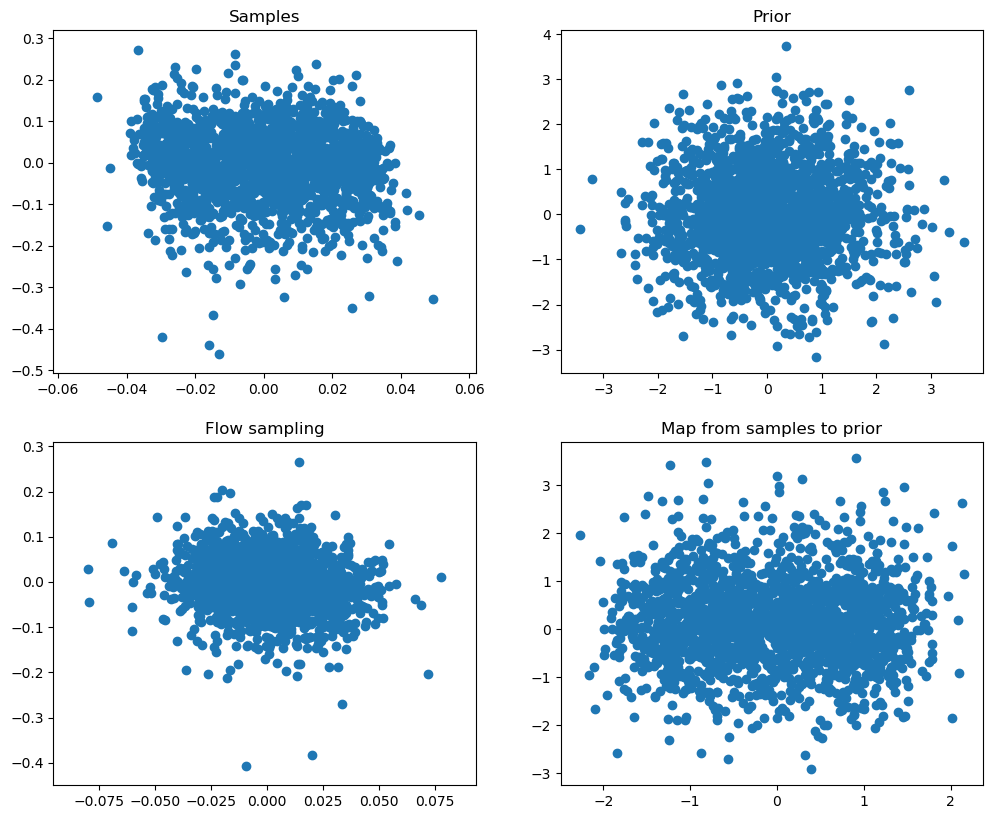

computing Arc model...
{'nll': 0.17552621344725292, 'loss': 0.17552621344725292, 'accuracy': 96.03}
{'nll': 0.18263948655128479, 'loss': 0.18263948655128479, 'accuracy': 95.59}
computing Sampling from flow model...
{'nll': 0.4272068541844686, 'loss': 0.4272068541844686, 'accuracy': 86.84333333333333}
{'nll': 0.43045950980186465, 'loss': 0.43045950980186465, 'accuracy': 86.9}
epoch 11: loss = -2186.174 time = 3.07
epoch 12: loss = -2200.189 time = 3.06
epoch 13: loss = -2212.802 time = 3.07
epoch 14: loss = -2224.354 time = 3.07
epoch 15: loss = -2234.928 time = 3.06
epoch 16: loss = -2244.564 time = 3.06
epoch 17: loss = -2253.128 time = 3.07
epoch 18: loss = -2261.785 time = 3.06
epoch 19: loss = -2269.293 time = 3.06
epoch 20: loss = -2276.399 time = 3.05
copmuting samples...
drawing...


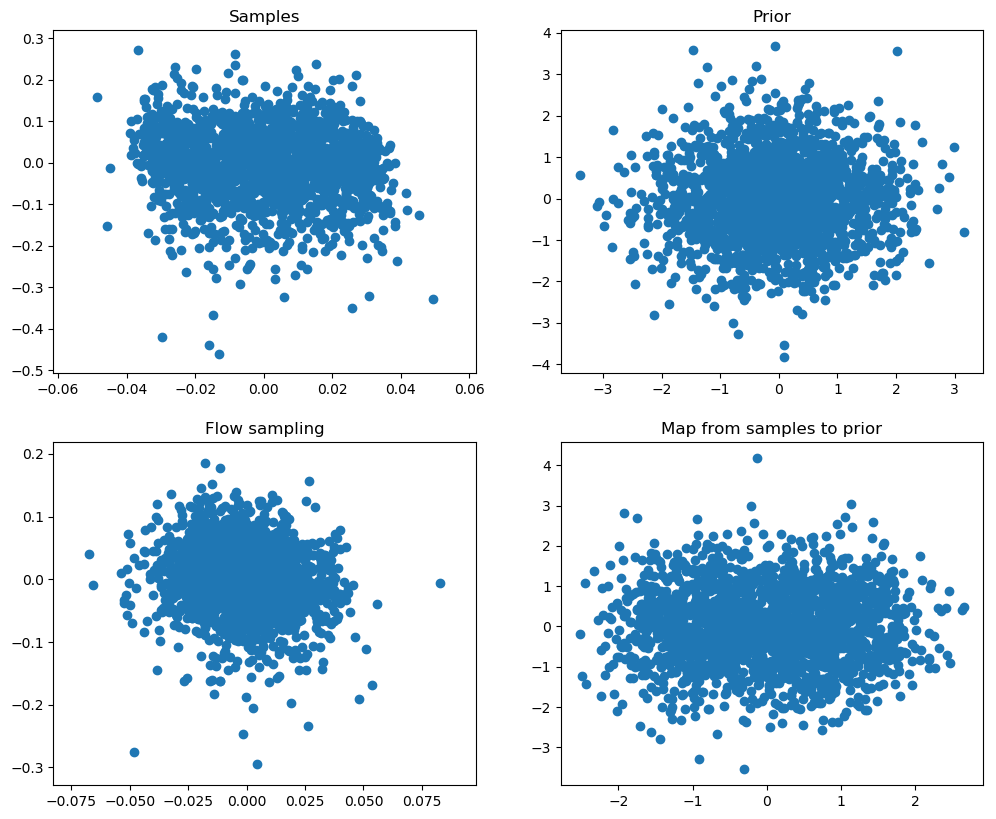

computing Arc model...
{'nll': 0.259220397400856, 'loss': 0.259220397400856, 'accuracy': 93.87666666666667}
{'nll': 0.2610123306274414, 'loss': 0.2610123306274414, 'accuracy': 93.42}
computing Sampling from flow model...
{'nll': 0.3986204579512278, 'loss': 0.3986204579512278, 'accuracy': 90.26}
{'nll': 0.39212320551872254, 'loss': 0.39212320551872254, 'accuracy': 90.58}
epoch 21: loss = -2283.274 time = 3.08
epoch 22: loss = -2290.056 time = 3.07
epoch 23: loss = -2296.187 time = 3.07
epoch 24: loss = -2301.297 time = 3.08
epoch 25: loss = -2307.298 time = 3.07
epoch 26: loss = -2312.043 time = 3.07
epoch 27: loss = -2317.025 time = 3.07
epoch 28: loss = -2321.971 time = 3.07
epoch 29: loss = -2325.746 time = 3.07
epoch 30: loss = -2330.146 time = 3.08
copmuting samples...
drawing...


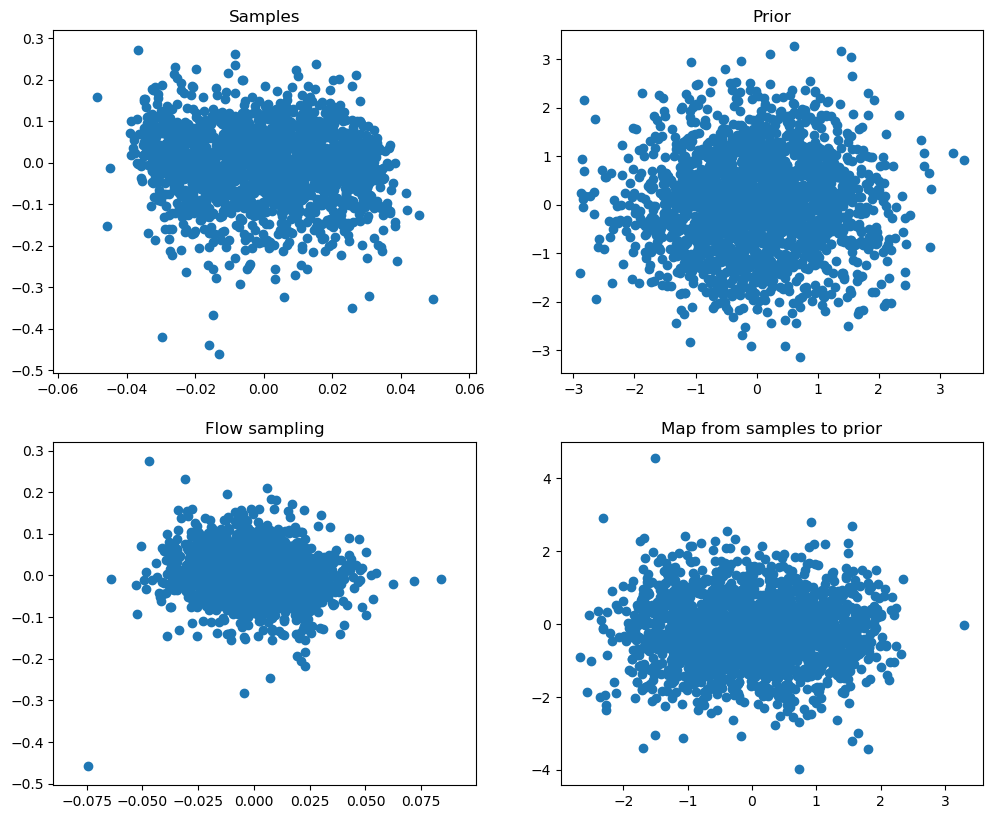

computing Arc model...
{'nll': 0.29171567680040994, 'loss': 0.29171567680040994, 'accuracy': 93.365}
{'nll': 0.29771511015892027, 'loss': 0.29771511015892027, 'accuracy': 93.16}
computing Sampling from flow model...
{'nll': 1.2503260979970297, 'loss': 1.2503260979970297, 'accuracy': 57.55}
{'nll': 1.2398494543075562, 'loss': 1.2398494543075562, 'accuracy': 58.38}
epoch 31: loss = -2334.928 time = 3.07
epoch 32: loss = -2339.041 time = 3.07
epoch 33: loss = -2342.612 time = 3.07
epoch 34: loss = -2346.015 time = 3.08
epoch 35: loss = -2350.037 time = 3.07
epoch 36: loss = -2353.646 time = 3.08
epoch 37: loss = -2355.856 time = 3.07
epoch 38: loss = -2359.962 time = 3.07
epoch 39: loss = -2362.469 time = 3.07
epoch 40: loss = -2366.095 time = 3.07
copmuting samples...
drawing...


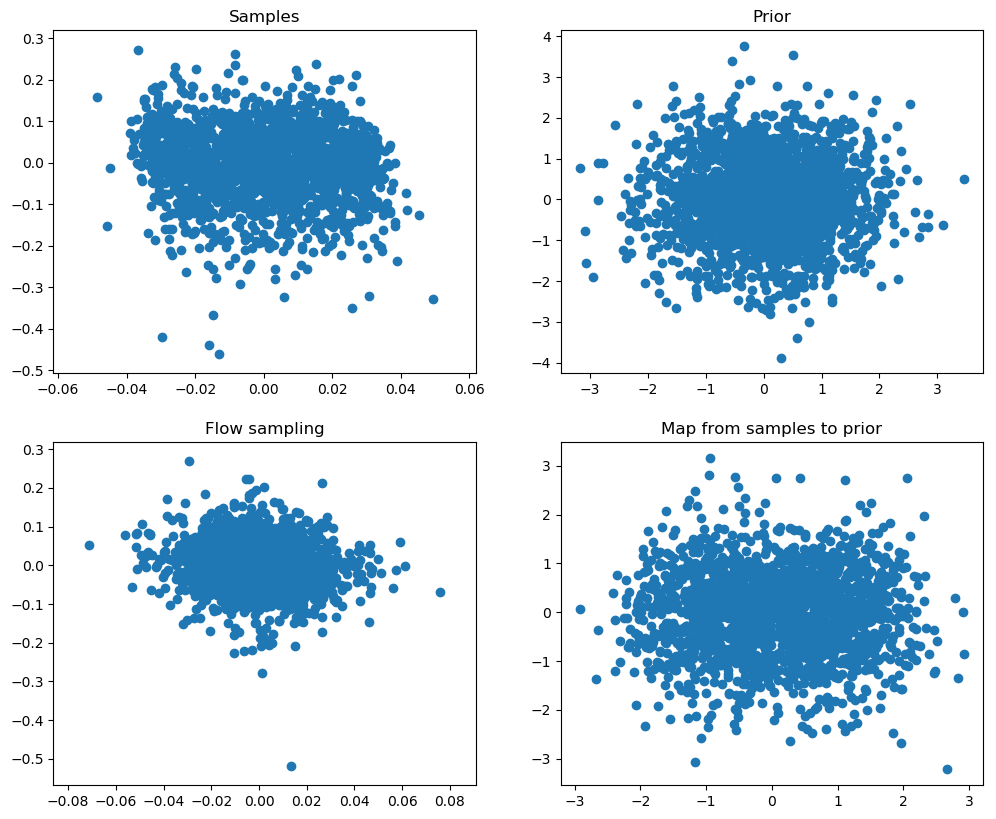

computing Arc model...
{'nll': 0.35809284122784935, 'loss': 0.35809284122784935, 'accuracy': 89.91833333333334}
{'nll': 0.3584605494022369, 'loss': 0.3584605494022369, 'accuracy': 89.88}
computing Sampling from flow model...
{'nll': 0.679630797290802, 'loss': 0.679630797290802, 'accuracy': 73.90166666666667}
{'nll': 0.6937778451919555, 'loss': 0.6937778451919555, 'accuracy': 73.47}
epoch 41: loss = -2368.414 time = 3.08
epoch 42: loss = -2372.103 time = 3.07
epoch 43: loss = -2374.257 time = 3.08
epoch 44: loss = -2377.223 time = 3.07
epoch 45: loss = -2380.013 time = 3.07
epoch 46: loss = -2382.603 time = 3.08
epoch 47: loss = -2384.781 time = 3.08
epoch 48: loss = -2387.368 time = 3.07
epoch 49: loss = -2390.127 time = 3.07
epoch 50: loss = -2392.350 time = 3.08
copmuting samples...
drawing...


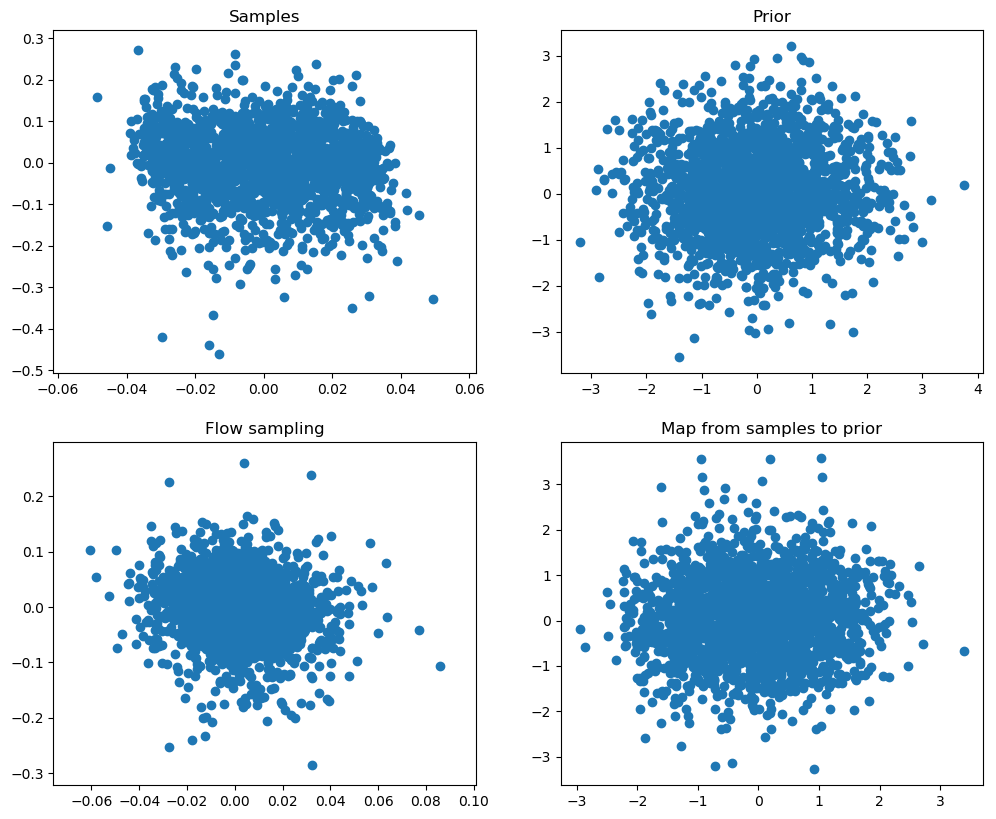

computing Arc model...
{'nll': 0.325738027715683, 'loss': 0.325738027715683, 'accuracy': 91.445}
{'nll': 0.32678157567977906, 'loss': 0.32678157567977906, 'accuracy': 91.21}
computing Sampling from flow model...
{'nll': 0.37131593276659647, 'loss': 0.37131593276659647, 'accuracy': 91.36833333333334}
{'nll': 0.3736207128047943, 'loss': 0.3736207128047943, 'accuracy': 91.19}
epoch 51: loss = -2400.626 time = 3.09
epoch 52: loss = -2408.516 time = 3.08
epoch 53: loss = -2409.672 time = 3.07
epoch 54: loss = -2411.516 time = 3.08
epoch 55: loss = -2414.098 time = 3.07
epoch 56: loss = -2415.550 time = 3.08
epoch 57: loss = -2417.357 time = 3.08
epoch 58: loss = -2419.156 time = 3.07
epoch 59: loss = -2421.610 time = 3.12
epoch 60: loss = -2423.883 time = 3.08
copmuting samples...
drawing...


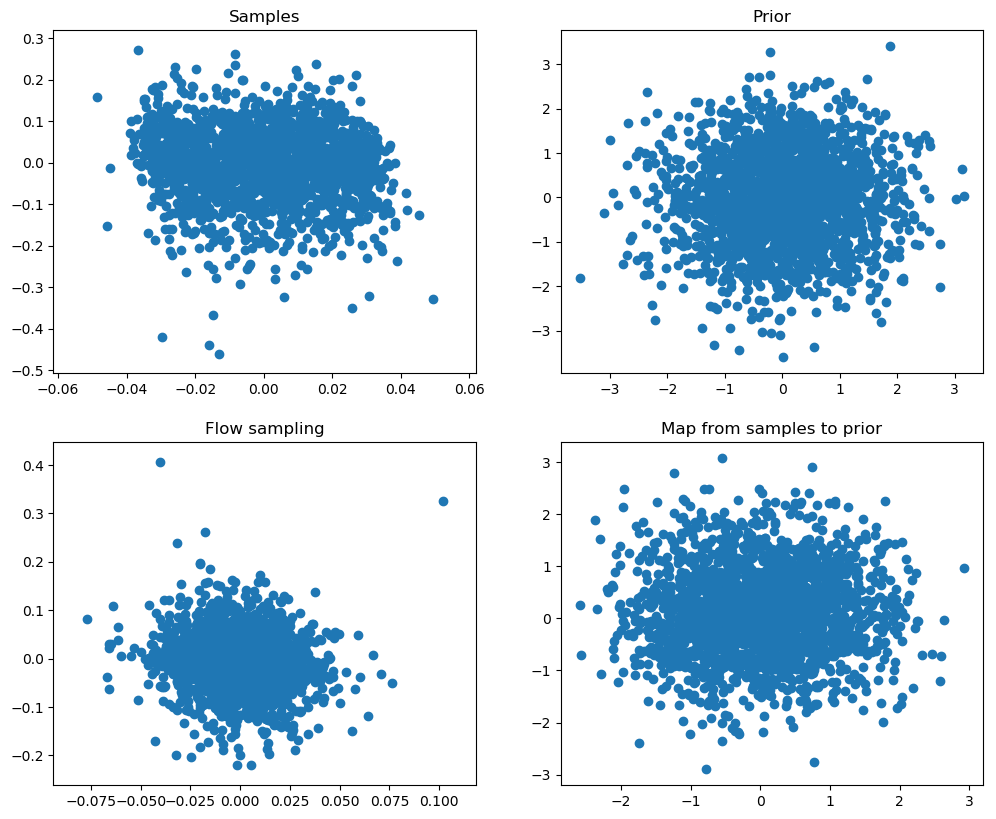

computing Arc model...
{'nll': 0.3365529652118683, 'loss': 0.3365529652118683, 'accuracy': 91.70666666666666}
{'nll': 0.3456986615896225, 'loss': 0.3456986615896225, 'accuracy': 91.31}
computing Sampling from flow model...
{'nll': 0.7762510823249817, 'loss': 0.7762510823249817, 'accuracy': 70.72833333333334}
{'nll': 0.7843528602600097, 'loss': 0.7843528602600097, 'accuracy': 70.92}
epoch 61: loss = -2424.649 time = 3.09
epoch 62: loss = -2426.831 time = 3.08
epoch 63: loss = -2429.072 time = 3.08
epoch 64: loss = -2430.414 time = 3.08
epoch 65: loss = -2431.760 time = 3.08
epoch 66: loss = -2433.529 time = 3.07
epoch 67: loss = -2435.442 time = 3.08
epoch 68: loss = -2436.884 time = 3.07
epoch 69: loss = -2439.119 time = 3.08
epoch 70: loss = -2440.372 time = 3.08
copmuting samples...
drawing...


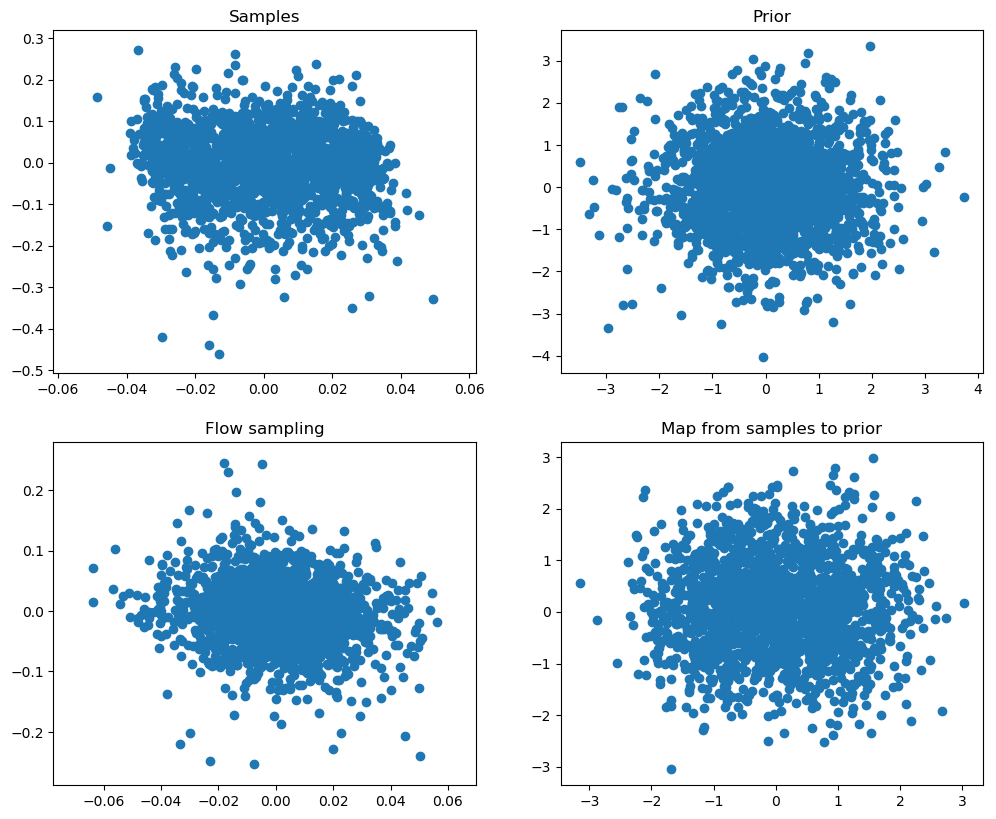

computing Arc model...
{'nll': 0.5671996523221334, 'loss': 0.5671996523221334, 'accuracy': 78.55333333333333}
{'nll': 0.5688871066093445, 'loss': 0.5688871066093445, 'accuracy': 78.71}
computing Sampling from flow model...
{'nll': 0.5312427661736806, 'loss': 0.5312427661736806, 'accuracy': 82.55333333333333}
{'nll': 0.5297774816513061, 'loss': 0.5297774816513061, 'accuracy': 82.78}
epoch 71: loss = -2441.575 time = 3.10
epoch 72: loss = -2443.328 time = 3.08
epoch 73: loss = -2445.652 time = 3.08
epoch 74: loss = -2446.954 time = 3.08
epoch 75: loss = -2448.051 time = 3.08
epoch 76: loss = -2449.331 time = 3.08
epoch 77: loss = -2450.885 time = 3.08
epoch 78: loss = -2452.414 time = 3.07
epoch 79: loss = -2453.679 time = 3.08
epoch 80: loss = -2454.098 time = 3.08
copmuting samples...
drawing...


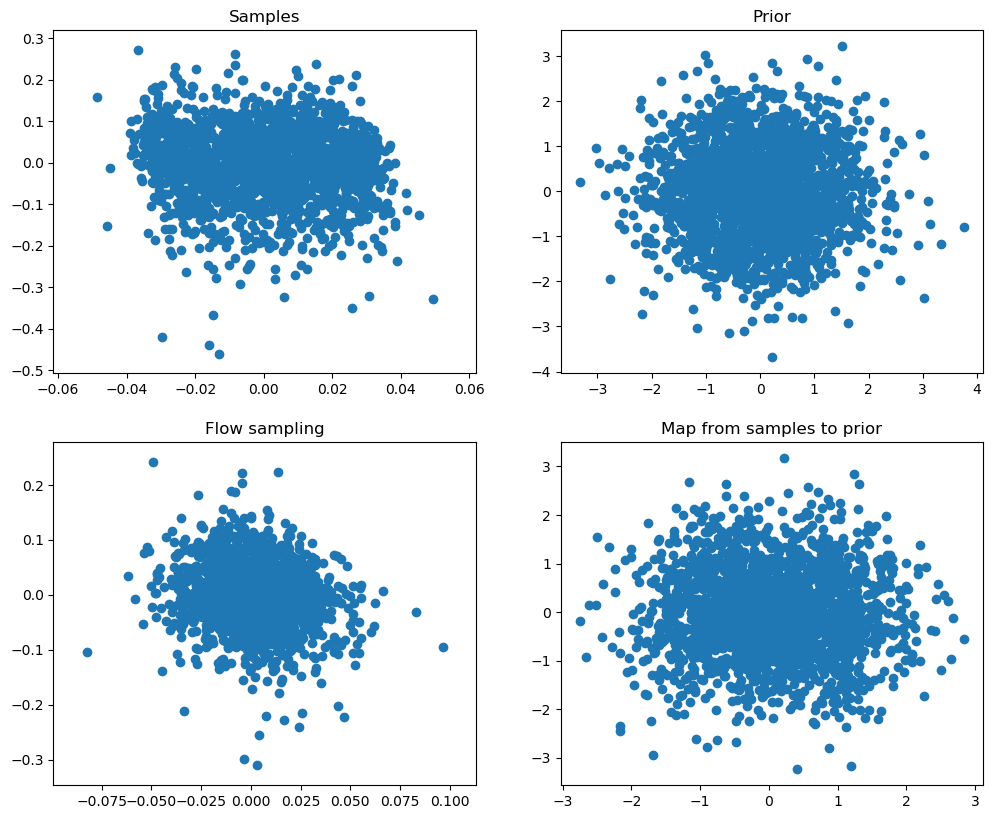

computing Arc model...
{'nll': 0.40489730156262715, 'loss': 0.40489730156262715, 'accuracy': 88.40833333333333}
{'nll': 0.4083793485641479, 'loss': 0.4083793485641479, 'accuracy': 88.54}
computing Sampling from flow model...
{'nll': 0.6240668073972067, 'loss': 0.6240668073972067, 'accuracy': 79.25333333333333}
{'nll': 0.6284698894500732, 'loss': 0.6284698894500732, 'accuracy': 79.06}
epoch 81: loss = -2456.146 time = 3.08
epoch 82: loss = -2457.964 time = 3.08
epoch 83: loss = -2458.931 time = 3.08
epoch 84: loss = -2460.501 time = 3.08
epoch 85: loss = -2461.734 time = 3.08
epoch 86: loss = -2462.060 time = 3.08
epoch 87: loss = -2463.370 time = 3.08
epoch 88: loss = -2464.833 time = 3.08
epoch 89: loss = -2465.718 time = 3.09
epoch 90: loss = -2466.811 time = 3.08
copmuting samples...
drawing...


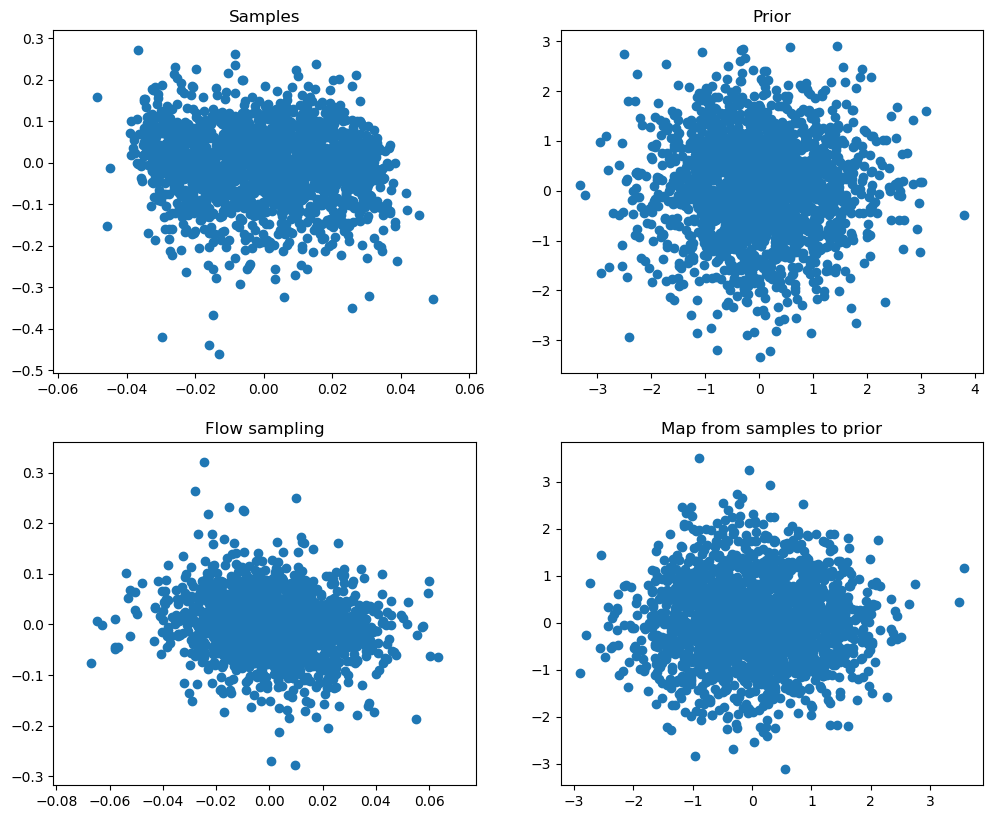

computing Arc model...
{'nll': 0.7652484110196431, 'loss': 0.7652484110196431, 'accuracy': 68.44833333333334}
{'nll': 0.775641498374939, 'loss': 0.775641498374939, 'accuracy': 68.35}
computing Sampling from flow model...
{'nll': 0.44820611012776695, 'loss': 0.44820611012776695, 'accuracy': 86.73}
{'nll': 0.4379072264671326, 'loss': 0.4379072264671326, 'accuracy': 87.01}
epoch 91: loss = -2468.188 time = 3.08
epoch 92: loss = -2469.248 time = 3.07
epoch 93: loss = -2469.466 time = 3.08
epoch 94: loss = -2471.928 time = 3.08
epoch 95: loss = -2472.763 time = 3.08
epoch 96: loss = -2472.404 time = 3.08
epoch 97: loss = -2474.509 time = 3.07
epoch 98: loss = -2475.668 time = 3.08
epoch 99: loss = -2476.725 time = 3.08
epoch 100: loss = -2477.638 time = 3.08
copmuting samples...
drawing...


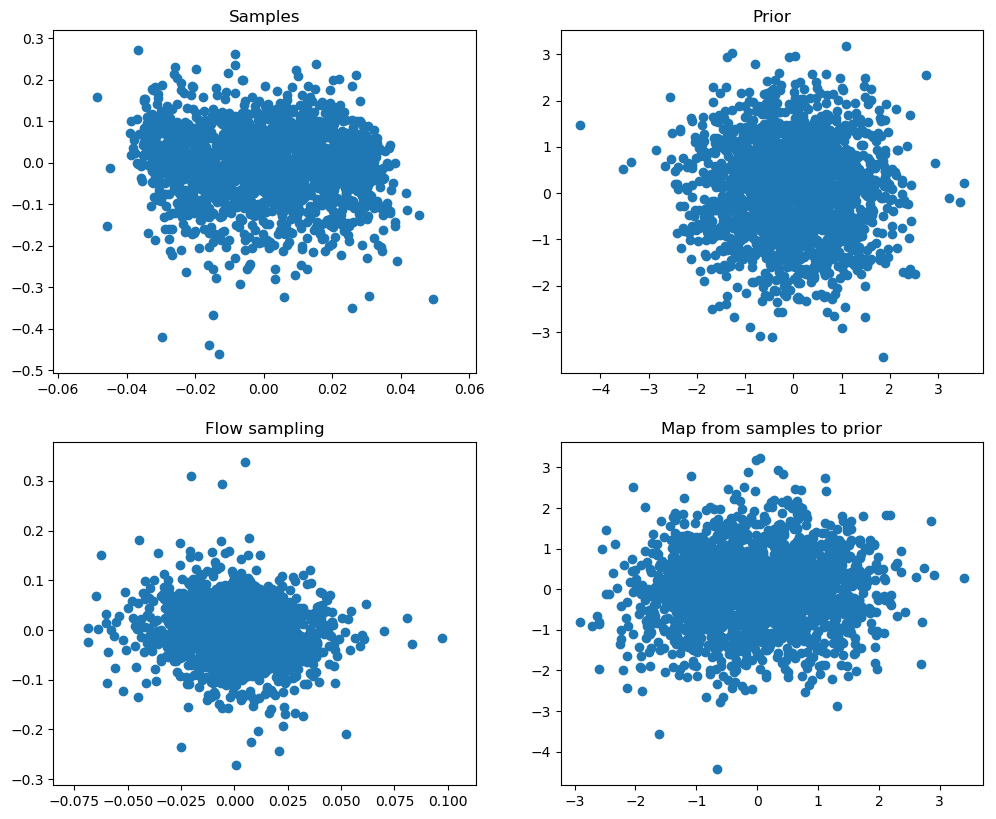

computing Arc model...
{'nll': 0.8055069208780925, 'loss': 0.8055069208780925, 'accuracy': 66.69}
{'nll': 0.8135370042800903, 'loss': 0.8135370042800903, 'accuracy': 66.43}
computing Sampling from flow model...
{'nll': 0.5406913154125214, 'loss': 0.5406913154125214, 'accuracy': 82.09666666666666}
{'nll': 0.5414959170341491, 'loss': 0.5414959170341491, 'accuracy': 81.91}
epoch 101: loss = -2484.635 time = 3.08
epoch 102: loss = -2494.246 time = 3.08
epoch 103: loss = -2494.000 time = 3.08
epoch 104: loss = -2492.602 time = 3.07
epoch 105: loss = -2493.931 time = 3.08
epoch 106: loss = -2495.021 time = 3.08
epoch 107: loss = -2496.445 time = 3.08
epoch 108: loss = -2496.456 time = 3.08
epoch 109: loss = -2497.049 time = 3.08
epoch 110: loss = -2498.792 time = 3.08
copmuting samples...
drawing...


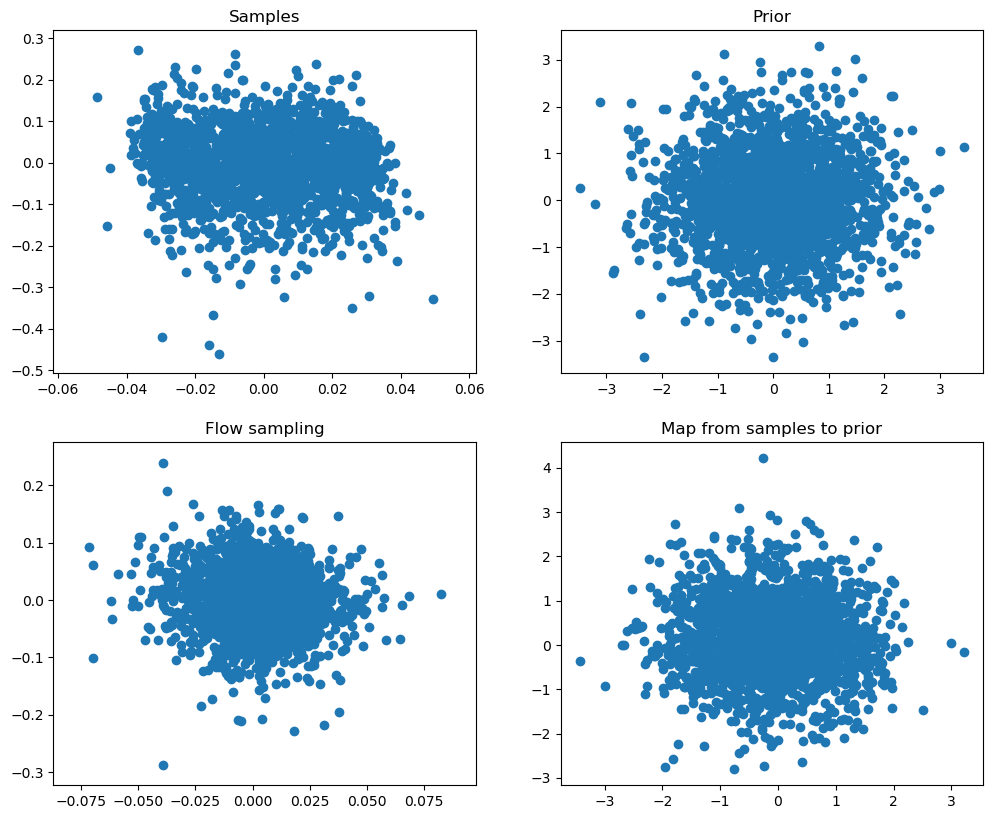

computing Arc model...
{'nll': 0.4877986456871033, 'loss': 0.4877986456871033, 'accuracy': 83.76}
{'nll': 0.4927642300605774, 'loss': 0.4927642300605774, 'accuracy': 83.72}
computing Sampling from flow model...
{'nll': 0.9481460687637329, 'loss': 0.9481460687637329, 'accuracy': 60.885}
{'nll': 0.9605026424407959, 'loss': 0.9605026424407959, 'accuracy': 61.13}
epoch 111: loss = -2498.941 time = 3.07
epoch 112: loss = -2499.988 time = 3.08
epoch 113: loss = -2501.654 time = 3.07
epoch 114: loss = -2502.389 time = 3.08
epoch 115: loss = -2503.277 time = 3.08
epoch 116: loss = -2503.245 time = 3.08
epoch 117: loss = -2504.380 time = 3.08
epoch 118: loss = -2505.967 time = 3.08
epoch 119: loss = -2506.442 time = 3.07
epoch 120: loss = -2507.722 time = 3.19
copmuting samples...
drawing...


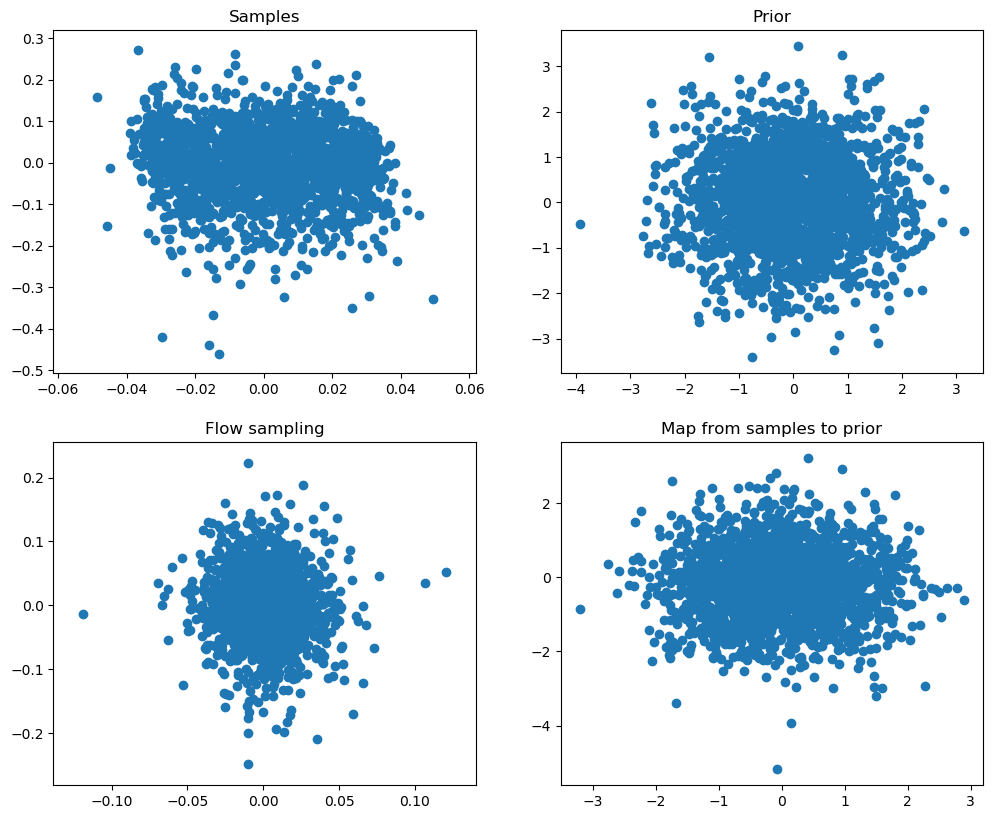

computing Arc model...
{'nll': 0.6916750021298727, 'loss': 0.6916750021298727, 'accuracy': 74.335}
{'nll': 0.702604430103302, 'loss': 0.702604430103302, 'accuracy': 74.39}
computing Sampling from flow model...
{'nll': 0.9213949313163757, 'loss': 0.9213949313163757, 'accuracy': 62.345}
{'nll': 0.9196173932075501, 'loss': 0.9196173932075501, 'accuracy': 63.0}
epoch 121: loss = -2508.345 time = 3.08
epoch 122: loss = -2509.216 time = 3.07
epoch 123: loss = -2509.738 time = 3.07
epoch 124: loss = -2509.053 time = 3.07
epoch 125: loss = -2511.139 time = 3.07
epoch 126: loss = -2512.772 time = 3.07
epoch 127: loss = -2512.761 time = 3.07
epoch 128: loss = -2513.594 time = 3.08
epoch 129: loss = -2514.313 time = 3.08
epoch 130: loss = -2514.660 time = 3.08
copmuting samples...
drawing...


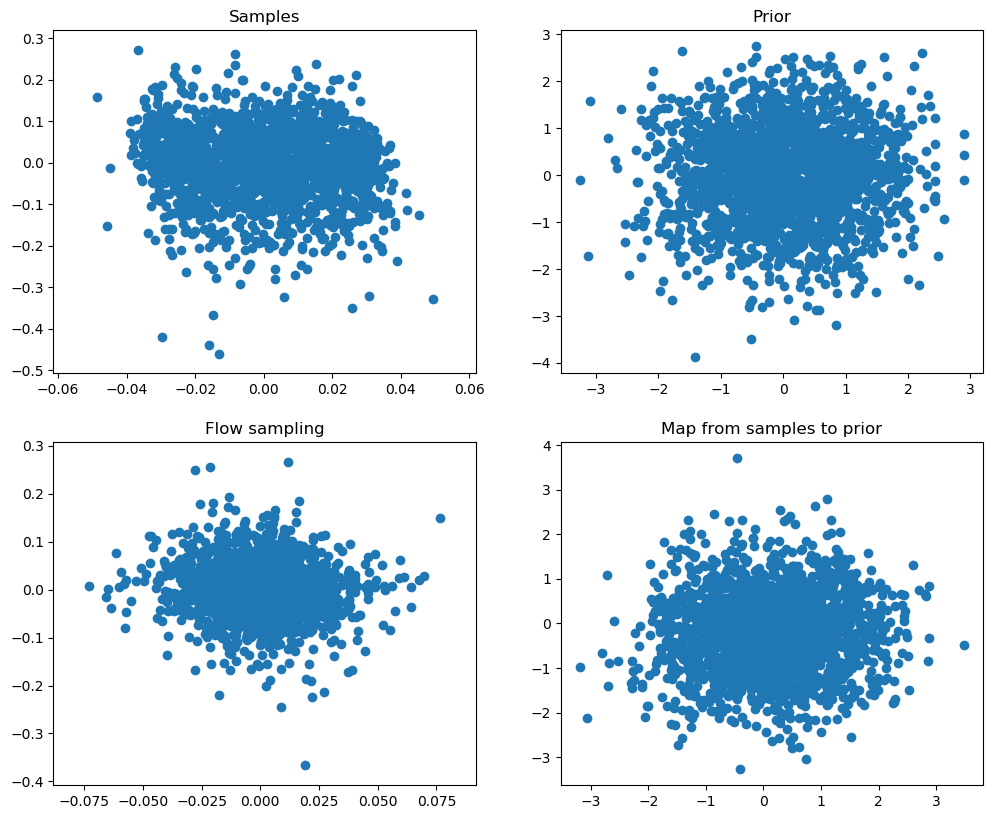

computing Arc model...
{'nll': 0.4137460263411204, 'loss': 0.4137460263411204, 'accuracy': 88.77}
{'nll': 0.42100528049468994, 'loss': 0.42100528049468994, 'accuracy': 88.45}
computing Sampling from flow model...
{'nll': 1.2724097642262777, 'loss': 1.2724097642262777, 'accuracy': 57.29666666666667}
{'nll': 1.2590453098297119, 'loss': 1.2590453098297119, 'accuracy': 58.38}
epoch 131: loss = -2515.950 time = 3.07
epoch 132: loss = -2516.946 time = 3.07
epoch 133: loss = -2518.179 time = 3.08
epoch 134: loss = -2516.898 time = 3.07
epoch 135: loss = -2518.964 time = 3.07
epoch 136: loss = -2519.118 time = 3.07
epoch 137: loss = -2519.869 time = 3.08
epoch 138: loss = -2520.855 time = 3.07
epoch 139: loss = -2520.898 time = 3.07
epoch 140: loss = -2522.199 time = 3.07
copmuting samples...
drawing...


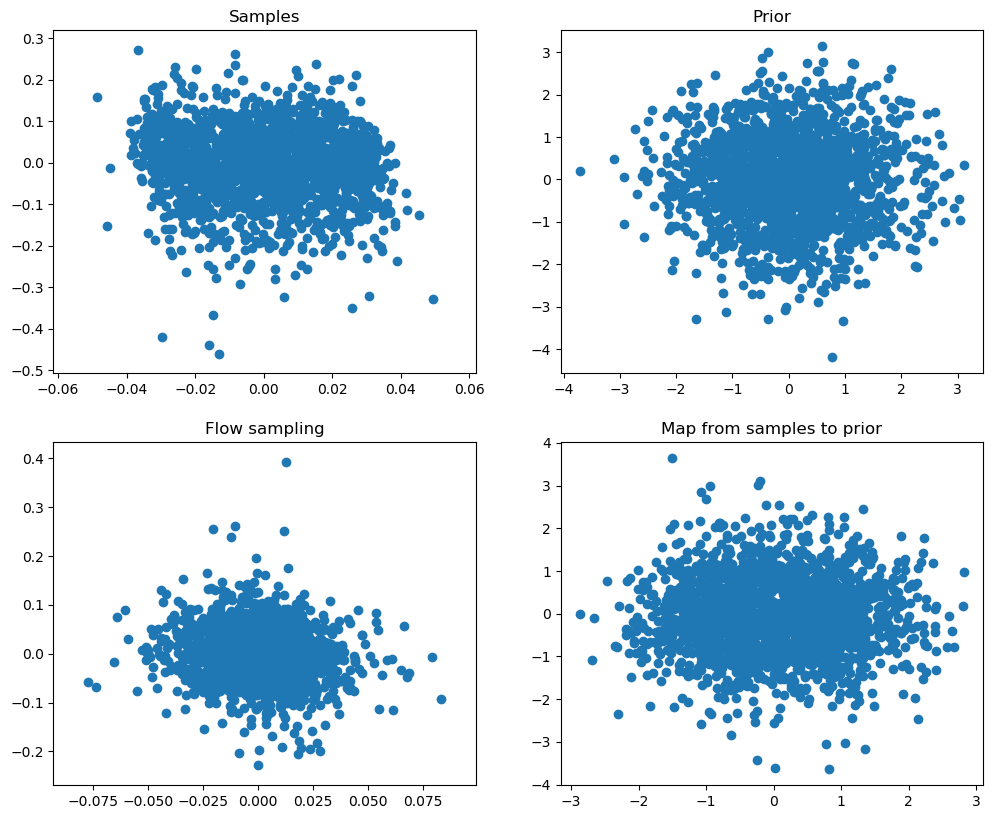

computing Arc model...
{'nll': 0.510603038597107, 'loss': 0.510603038597107, 'accuracy': 82.07166666666667}
{'nll': 0.5174654059886933, 'loss': 0.5174654059886933, 'accuracy': 82.14}
computing Sampling from flow model...
{'nll': 0.5185620332082113, 'loss': 0.5185620332082113, 'accuracy': 82.86833333333334}
{'nll': 0.5208177987098694, 'loss': 0.5208177987098694, 'accuracy': 82.79}
epoch 141: loss = -2522.645 time = 3.08
epoch 142: loss = -2523.815 time = 3.07
epoch 143: loss = -2524.499 time = 3.07
epoch 144: loss = -2525.062 time = 3.07
epoch 145: loss = -2524.574 time = 3.07
epoch 146: loss = -2525.025 time = 3.07
epoch 147: loss = -2524.942 time = 3.07
epoch 148: loss = -2527.096 time = 3.07
epoch 149: loss = -2527.122 time = 3.07
epoch 150: loss = -2527.700 time = 3.07
copmuting samples...
drawing...


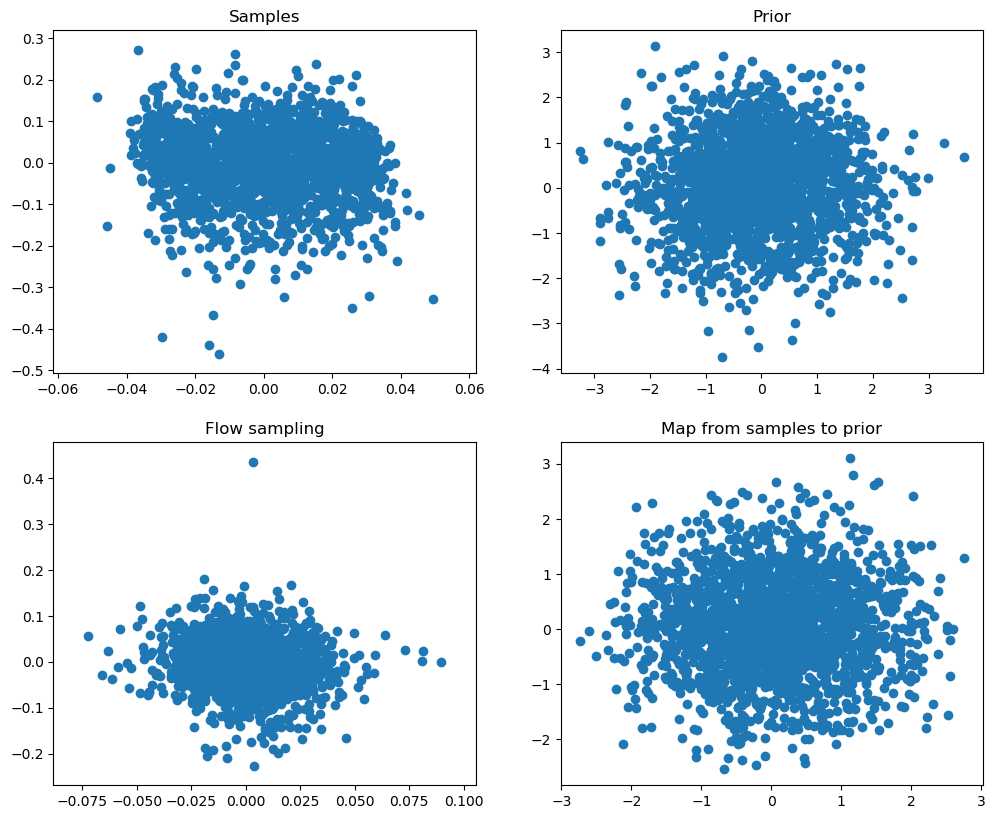

computing Arc model...
{'nll': 0.7504883385658264, 'loss': 0.7504883385658264, 'accuracy': 71.1}
{'nll': 0.7629982175827026, 'loss': 0.7629982175827026, 'accuracy': 70.43}
computing Sampling from flow model...
{'nll': 0.6929247442563374, 'loss': 0.6929247442563374, 'accuracy': 73.62666666666667}
{'nll': 0.7118572359085082, 'loss': 0.7118572359085082, 'accuracy': 73.24}
epoch 151: loss = -2534.744 time = 3.08
epoch 152: loss = -2543.433 time = 3.07
epoch 153: loss = -2542.944 time = 3.06
epoch 154: loss = -2542.938 time = 3.07
epoch 155: loss = -2543.264 time = 3.07
epoch 156: loss = -2544.006 time = 3.07
epoch 157: loss = -2544.167 time = 3.06
epoch 158: loss = -2544.430 time = 3.07
epoch 159: loss = -2544.053 time = 3.07
epoch 160: loss = -2545.392 time = 3.07
copmuting samples...
drawing...


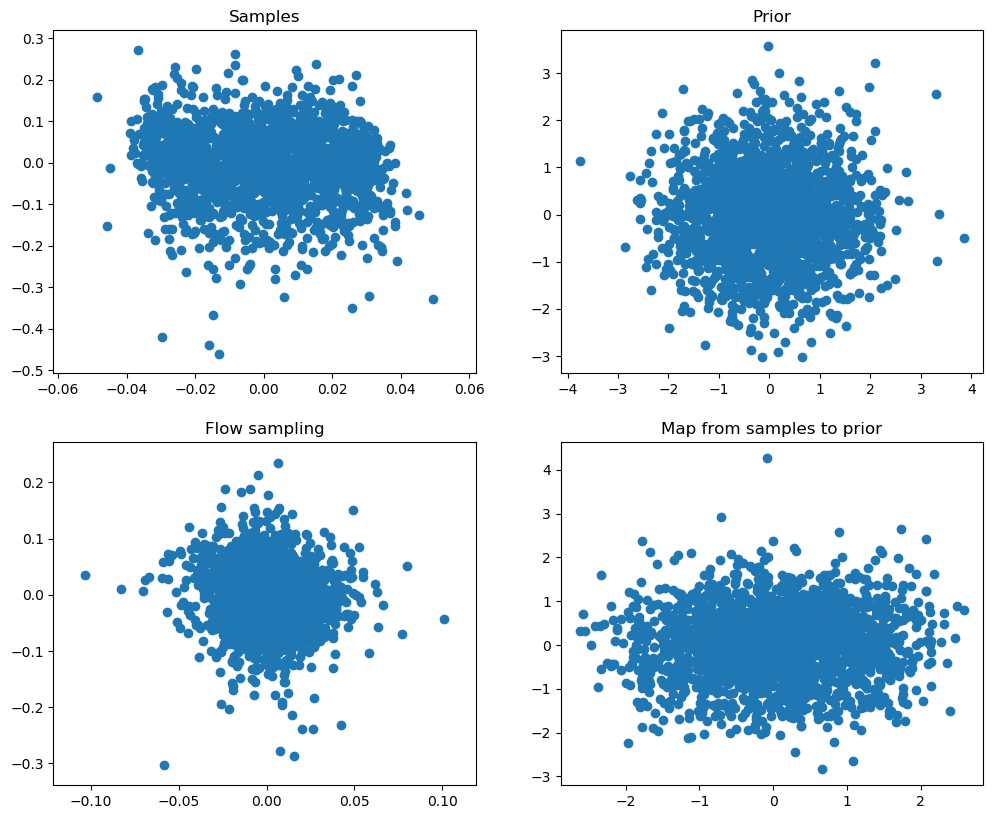

computing Arc model...
{'nll': 0.7799516710917155, 'loss': 0.7799516710917155, 'accuracy': 69.505}
{'nll': 0.7879661058425903, 'loss': 0.7879661058425903, 'accuracy': 70.03}
computing Sampling from flow model...
{'nll': 0.45649906895955406, 'loss': 0.45649906895955406, 'accuracy': 85.40666666666667}
{'nll': 0.4489253519058228, 'loss': 0.4489253519058228, 'accuracy': 85.7}
epoch 161: loss = -2546.328 time = 3.07
epoch 162: loss = -2546.039 time = 3.06
epoch 163: loss = -2547.234 time = 3.06
epoch 164: loss = -2548.211 time = 3.06
epoch 165: loss = -2548.211 time = 3.07
epoch 166: loss = -2549.292 time = 3.07
epoch 167: loss = -2550.023 time = 3.07
epoch 168: loss = -2550.772 time = 3.07
epoch 169: loss = -2551.361 time = 3.07
epoch 170: loss = -2551.785 time = 3.07
copmuting samples...
drawing...


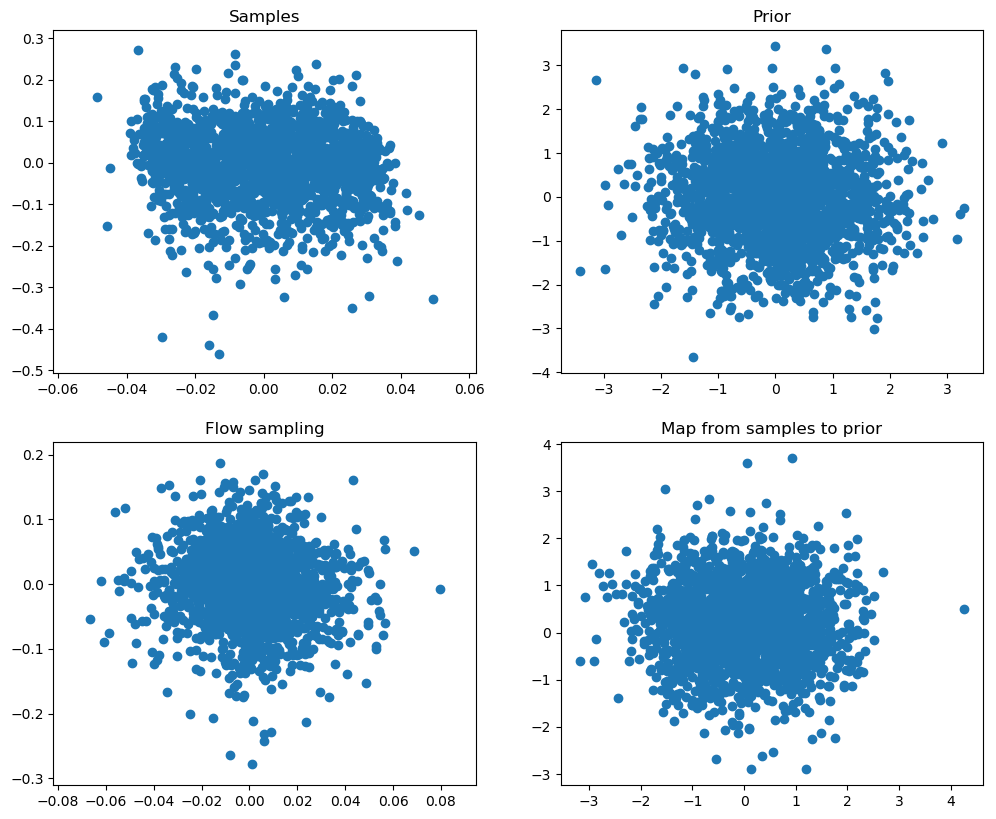

computing Arc model...
{'nll': 0.641302781422933, 'loss': 0.641302781422933, 'accuracy': 75.89833333333333}
{'nll': 0.6457943121910095, 'loss': 0.6457943121910095, 'accuracy': 75.8}
computing Sampling from flow model...
{'nll': 0.5330503387133281, 'loss': 0.5330503387133281, 'accuracy': 81.32166666666667}
{'nll': 0.5308336067199707, 'loss': 0.5308336067199707, 'accuracy': 81.74}
epoch 171: loss = -2551.198 time = 3.07
epoch 172: loss = -2551.702 time = 3.07
epoch 173: loss = -2553.004 time = 3.06
epoch 174: loss = -2553.245 time = 3.06
epoch 175: loss = -2554.059 time = 3.07
epoch 176: loss = -2554.840 time = 3.07
epoch 177: loss = -2555.098 time = 3.07
epoch 178: loss = -2556.304 time = 3.07
epoch 179: loss = -2556.115 time = 3.07
epoch 180: loss = -2556.726 time = 3.07
copmuting samples...
drawing...


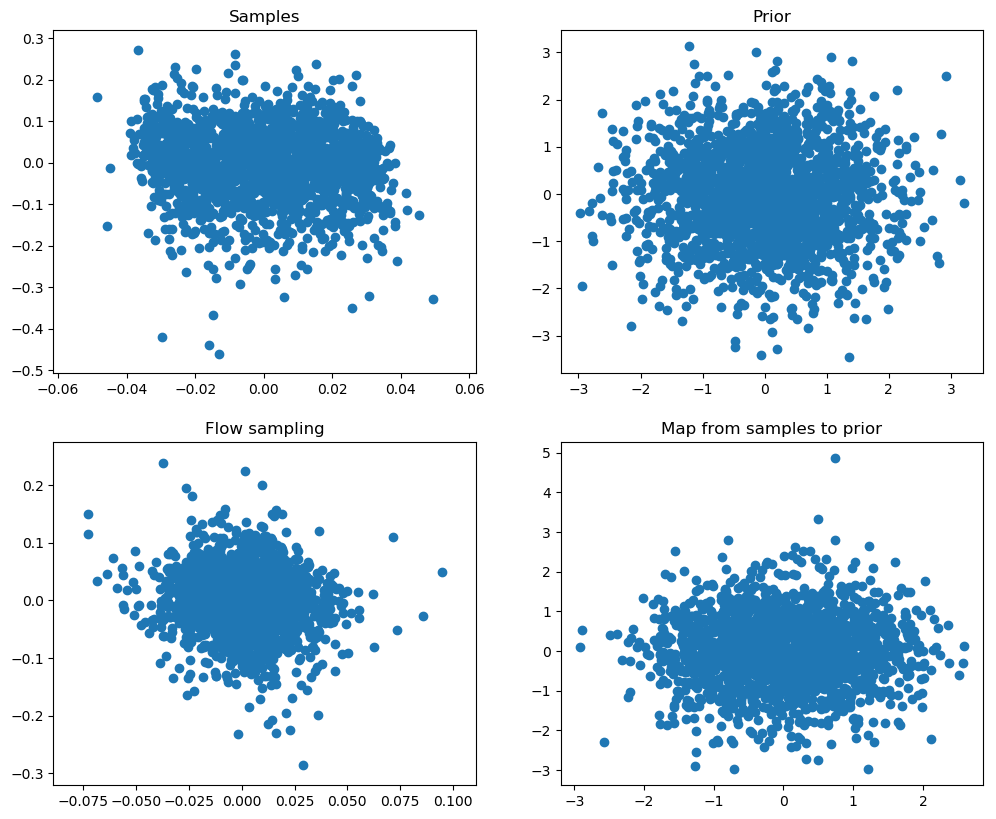

computing Arc model...
{'nll': 0.750885517247518, 'loss': 0.750885517247518, 'accuracy': 67.99}
{'nll': 0.759864094543457, 'loss': 0.759864094543457, 'accuracy': 68.24}
computing Sampling from flow model...
{'nll': 0.8486367545127869, 'loss': 0.8486367545127869, 'accuracy': 70.40333333333334}
{'nll': 0.8528927436828613, 'loss': 0.8528927436828613, 'accuracy': 70.48}
epoch 181: loss = -2557.697 time = 3.07
epoch 182: loss = -2556.303 time = 3.07
epoch 183: loss = -2557.781 time = 3.06
epoch 184: loss = -2558.045 time = 3.07
epoch 185: loss = -2558.362 time = 3.06
epoch 186: loss = -2558.595 time = 3.07
epoch 187: loss = -2559.799 time = 3.07
epoch 188: loss = -2560.609 time = 3.07
epoch 189: loss = -2560.671 time = 3.07
epoch 190: loss = -2560.825 time = 3.07
copmuting samples...
drawing...


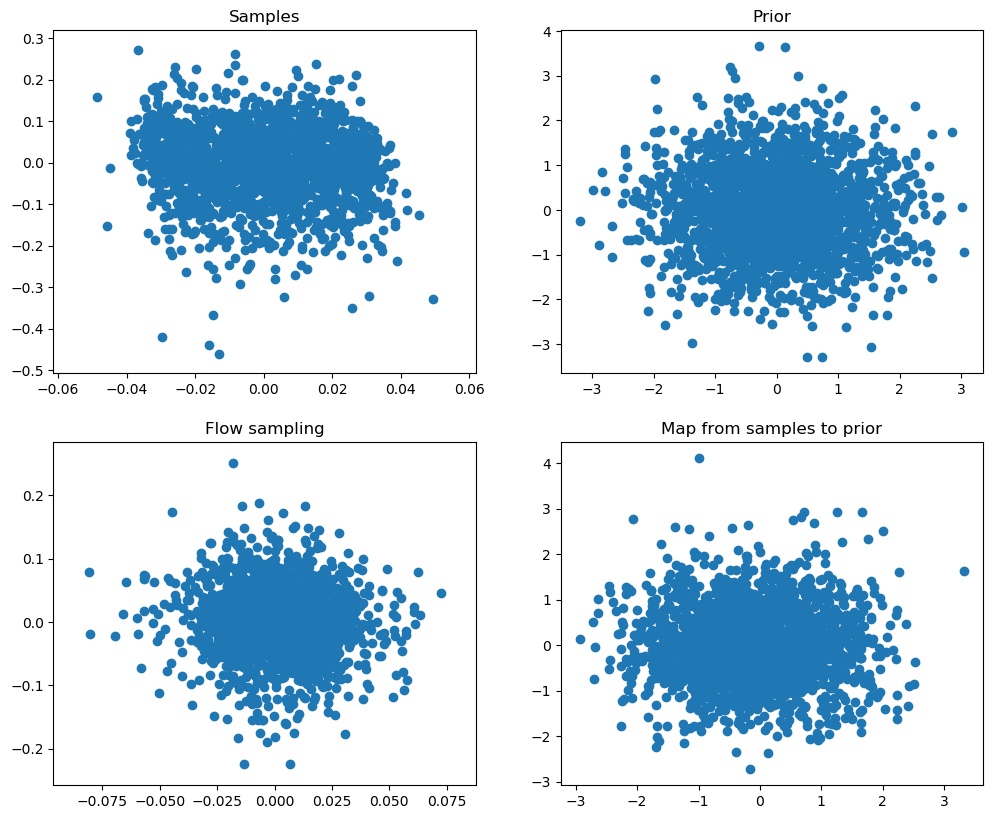

computing Arc model...
{'nll': 0.8049989353497823, 'loss': 0.8049989353497823, 'accuracy': 67.08833333333334}
{'nll': 0.8131570583343506, 'loss': 0.8131570583343506, 'accuracy': 67.51}
computing Sampling from flow model...
{'nll': 0.603686702187856, 'loss': 0.603686702187856, 'accuracy': 77.715}
{'nll': 0.6101983627319336, 'loss': 0.6101983627319336, 'accuracy': 77.29}
epoch 191: loss = -2561.707 time = 3.08
epoch 192: loss = -2562.291 time = 3.07
epoch 193: loss = -2559.638 time = 3.07
epoch 194: loss = -2562.461 time = 3.07
epoch 195: loss = -2563.429 time = 3.07
epoch 196: loss = -2563.335 time = 3.08
epoch 197: loss = -2563.784 time = 3.07
epoch 198: loss = -2564.713 time = 3.07
epoch 199: loss = -2564.958 time = 3.08
epoch 200: loss = -2565.382 time = 3.08
copmuting samples...
drawing...


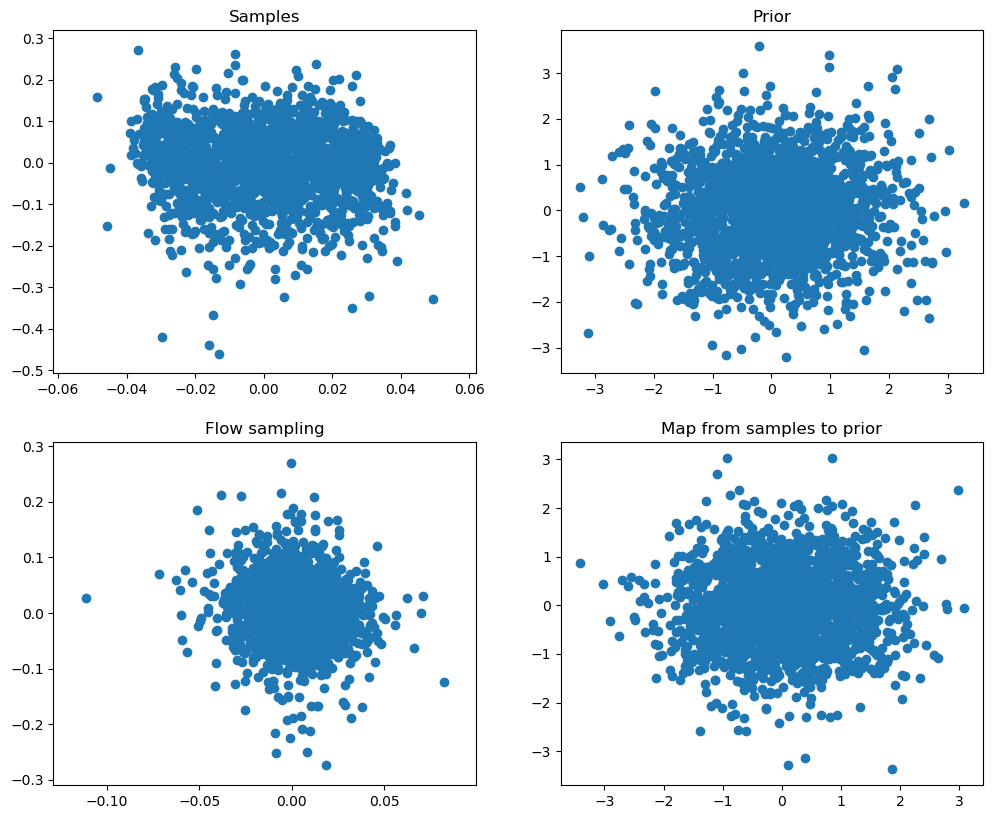

computing Arc model...
{'nll': 0.7904837232271831, 'loss': 0.7904837232271831, 'accuracy': 71.48}
{'nll': 0.7925158942222595, 'loss': 0.7925158942222595, 'accuracy': 71.5}
computing Sampling from flow model...
{'nll': 1.0575536635716756, 'loss': 1.0575536635716756, 'accuracy': 64.12333333333333}
{'nll': 1.0668660314559937, 'loss': 1.0668660314559937, 'accuracy': 64.51}
epoch 201: loss = -2572.165 time = 3.09
epoch 202: loss = -2579.749 time = 3.06
epoch 203: loss = -2579.706 time = 3.07
epoch 204: loss = -2579.337 time = 3.07
epoch 205: loss = -2579.805 time = 3.07
epoch 206: loss = -2580.193 time = 3.07
epoch 207: loss = -2580.229 time = 3.07
epoch 208: loss = -2580.829 time = 3.07
epoch 209: loss = -2581.993 time = 3.07
epoch 210: loss = -2582.371 time = 3.08
copmuting samples...
drawing...


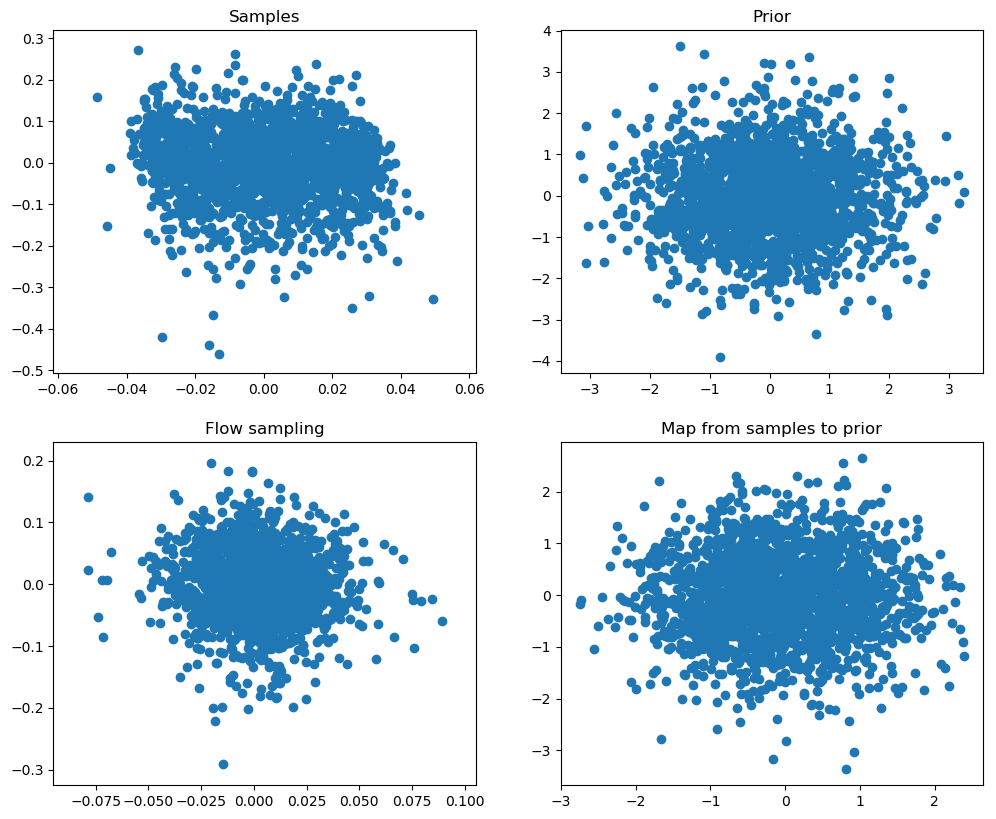

computing Arc model...
{'nll': 0.8687235605557759, 'loss': 0.8687235605557759, 'accuracy': 66.37}
{'nll': 0.8776587049484252, 'loss': 0.8776587049484252, 'accuracy': 66.18}
computing Sampling from flow model...
{'nll': 1.027958437983195, 'loss': 1.027958437983195, 'accuracy': 58.26}
{'nll': 1.0370635288238526, 'loss': 1.0370635288238526, 'accuracy': 58.44}
epoch 211: loss = -2582.351 time = 3.07
epoch 212: loss = -2582.749 time = 3.07
epoch 213: loss = -2582.982 time = 3.08
epoch 214: loss = -2583.545 time = 3.08
epoch 215: loss = -2583.244 time = 3.07
epoch 216: loss = -2583.580 time = 3.07
epoch 217: loss = -2584.972 time = 3.09
epoch 218: loss = -2586.004 time = 3.08
epoch 219: loss = -2585.170 time = 3.07
epoch 220: loss = -2585.264 time = 3.07
copmuting samples...
drawing...


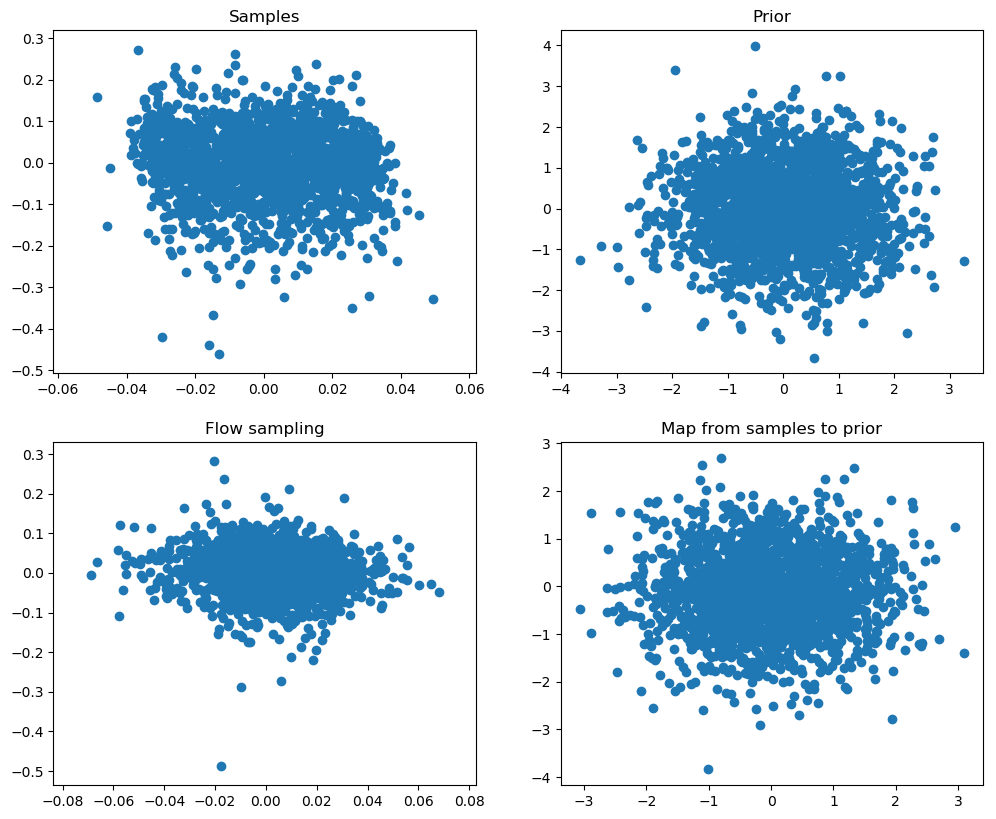

computing Arc model...
{'nll': 0.766897412109375, 'loss': 0.766897412109375, 'accuracy': 70.91333333333333}
{'nll': 0.7812853009223938, 'loss': 0.7812853009223938, 'accuracy': 70.98}
computing Sampling from flow model...
{'nll': 1.104134007581075, 'loss': 1.104134007581075, 'accuracy': 54.391666666666666}
{'nll': 1.0996748065948487, 'loss': 1.0996748065948487, 'accuracy': 54.83}
epoch 221: loss = -2586.014 time = 3.08
epoch 222: loss = -2586.396 time = 3.07
epoch 223: loss = -2586.605 time = 3.07
epoch 224: loss = -2587.364 time = 3.08
epoch 225: loss = -2587.074 time = 3.07
epoch 226: loss = -2587.658 time = 3.08
epoch 227: loss = -2587.765 time = 3.08
epoch 228: loss = -2588.736 time = 3.07
epoch 229: loss = -2589.567 time = 3.07
epoch 230: loss = -2590.213 time = 3.08
copmuting samples...


KeyboardInterrupt: 

In [22]:
train(IAF_flow, model1, model2, epochs=300, lr=1e-3, batchsize=1024, step=1, test_every=10)

In [ ]:
# os.makedirs('flows_checkpoints/IAFjn', exist_ok=True)
# utils.save_checkpoint(
#     'flows_checkpoints/IAFjn',
#     100,
#     model_state=IAF_flow.state_dict(),
#     optimizer_state=None
# )

In [ ]:
# checkpoint = torch.load('flows_checkpoints/IAFjn/checkpoint-100.pt')
# IAF_flow.load_state_dict(checkpoint['model_state'])

In [ ]:
# IAF_flow.eval()
# X_flow = IAF_flow.sample(1, ).data.cpu().numpy()

In [ ]:
# model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve1/checkpoint-30.pt')['model_state'])
# model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve2/checkpoint-30.pt')['model_state'])

# test_flow(S, model1, model2, IAF_flow, N=2000);